In [1]:
# In this notebook, we redo the analysis of chapter 8, but in Keras instead of scikit-learn
# Much of the initial dataset-building code is from there.

In [2]:
import numpy as np 
from PIL import Image, ImageDraw, ImageFont 
from skimage import transform as tf

In [3]:
def create_captcha(text, shear=0, size=(100, 30), scale=1):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"bretan/Coval-Black.otf", 22) 
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    image = image / image.max()
    shape = image.shape
    # Apply scale
    shapex, shapey = (shape[0] * scale, shape[1] * scale)
    image = tf.resize(image, (shapex, shapey))
    return image

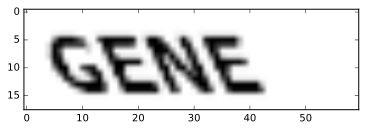

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5, scale=0.6)
plt.imshow(image, cmap='Greys')

In [5]:
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square

In [6]:
def segment_image(image):
    # label will find subimages of connected non-black pixels
    labeled_image = label(image>0.2, connectivity=1, background=0)
    subimages = []
    # regionprops splits up the subimages
    for region in regionprops(labeled_image):
        # Extract the subimage
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
    if len(subimages) == 0:
        # No subimages found, so return the entire image
        return [image,]
    return subimages

In [7]:
subimages = segment_image(image)

In [8]:
len(subimages)

4

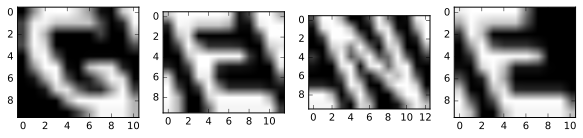

In [9]:
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3)) 
for i in range(len(subimages)): 
    axes[i].imshow(subimages[i], cmap="gray")

In [10]:
from sklearn.utils import check_random_state
random_state = check_random_state(14) 
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
assert len(letters) == 26
shear_values = np.arange(0, 0.8, 0.05)
scale_values = np.arange(0.9, 1.1, 0.1)

In [11]:
def generate_sample(random_state=None): 
    random_state = check_random_state(random_state) 
    letter = random_state.choice(letters) 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    return create_captcha(letter, shear=shear, size=(30, 30), scale=scale), letters.index(letter)

The target for this image is: L


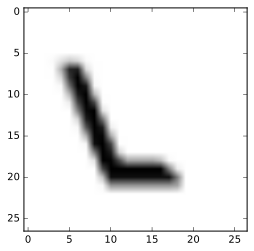

In [12]:
image, target = generate_sample(random_state) 
plt.imshow(image, cmap="Greys") 
print("The target for this image is: {0}".format(letters[target]))

In [13]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(1000)))
dataset = np.array([tf.resize(segment_image(sample)[0], (20, 20)) for sample in dataset])
dataset = np.array(dataset, dtype='float') 
targets = np.array(targets)

In [14]:
from sklearn.preprocessing import OneHotEncoder 
onehot = OneHotEncoder() 
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

In [15]:
y = y.todense()

In [16]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

In [17]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

# Classification

Here is the new Keras-based neural network

In [18]:
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [19]:
hidden_layer = Dense(100, input_dim=X_train.shape[1])
output_layer = Dense(y_train.shape[1])

In [20]:
model = Sequential(layers=[hidden_layer, output_layer])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [21]:
model.fit(X_train, y_train, nb_epoch=1000, verbose=False)

In [22]:
y_pred = model.predict(X_test)

from sklearn.metrics import f1_score


f1_score(y_pred=y_pred.argmax(axis=1), y_true=y_test.argmax(axis=1), average='macro')

1.0

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_pred=y_pred.argmax(axis=1),
                            y_true=y_test.argmax(axis=1)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       1.00      1.00      1.00         3
          2       1.00      1.00      1.00         4
          3       1.00      1.00      1.00         3
          4       1.00      1.00      1.00         6
          5       1.00      1.00      1.00         4
          6       1.00      1.00      1.00         2
          7       1.00      1.00      1.00         4
          8       1.00      1.00      1.00         8
          9       1.00      1.00      1.00         3
         10       1.00      1.00      1.00         3
         11       1.00      1.00      1.00         7
         12       1.00      1.00      1.00         7
         13       1.00      1.00      1.00         4
         14       1.00      1.00      1.00         3
         15       1.00      1.00      1.00         4
         16       1.00      1.00      1.00         3
         17       1.00      1.00      1.00   